In [100]:
#import modules
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')
import pandas as pd
import numpy as np
from rdkit import Chem
import deepchem as dc
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import scipy

#### Molecular Featurization

In [101]:
#transforming molecules into vectors of numbers (molecular featurizations)
#Extended-connectivity fingerprints (ECFPs)
featurizer = dc.feat.CircularFingerprint(size=1024)
loader = dc.data.CSVLoader(tasks=['Microsomal Clearance'],
                           feature_field="SMILES",
                           featurizer=featurizer)

train_dataset = loader.featurize("train_scaffold.csv")
valid_dataset = loader.featurize("valid_scaffold.csv")
test_dataset = loader.featurize("test_scaffold.csv")
#train_dataset, valid_dataset, test_dataset

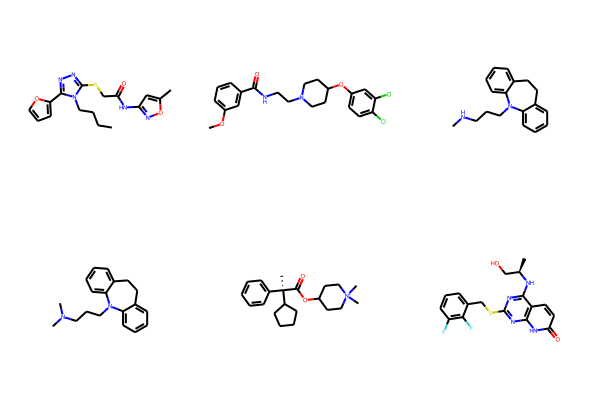

In [102]:
#visualize some molecules
train_mols = [Chem.MolFromSmiles(compound)
              for compound in train_dataset.ids]
Draw.MolsToGridImage(train_mols[:6])

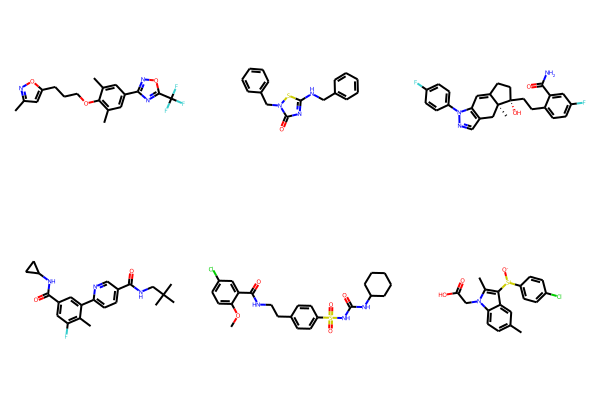

In [103]:
valid_mols = [Chem.MolFromSmiles(compound)
              for compound in valid_dataset.ids]
Draw.MolsToGridImage(valid_mols[:6])

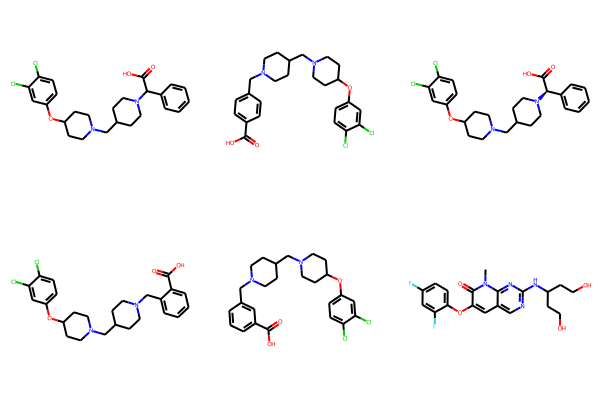

In [104]:
test_mols = [Chem.MolFromSmiles(compound)
              for compound in test_dataset.ids]
Draw.MolsToGridImage(test_mols[:6])

#### Training the RandomForestRegressor model

In [105]:
#normalizing the data with mean zero and standarad deviation 1
transformers = [
    dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset]:
    for transformer in transformers:
        dataset = transformer.transform(dataset)

In [106]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100)
model = dc.models.SklearnModel(regressor)
model.fit(train_dataset)

In [107]:
from deepchem.utils.evaluate import Evaluator

#metric = dc.metrics.Metric(dc.metrics.accuracy_score)
metric = dc.metrics.Metric(dc.metrics.r2_score)
#metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
evaluator = Evaluator(model, valid_dataset, transformers)
r2score = evaluator.compute_model_performance([metric])

print(r2score)

{'r2_score': 0.09913754452168233}


#### Optimizing the RandomForestRegressor model (Hyperparameter tuning)
<b>n_estimators</b>: the number of decision trees in the forest
<br>
<b>max_features</b>: the number of features to consider when splitting
<br>
<b>max_leaf_nodes</b>: maximum number of nodes a tree can have

In [122]:
def rf_model_builder(n_estimators, max_features, max_leaf_nodes, model_dir):
    sklearn_model = RandomForestRegressor( n_estimators=n_estimators, 
                                          max_features=max_features,
                                         max_leaf_nodes=max_leaf_nodes)
    return dc.models.SklearnModel(sklearn_model, model_dir)
params_dict = {
    "n_estimators": [10, 100, 200],
    "max_features": ["auto", "sqrt", "log2", None],
    "max_leaf_nodes":[8,16,32]
}

optimizer = dc.hyper.GridHyperparamOpt(rf_model_builder)
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, metric=metric, transformers=transformers)

In [123]:
best_rf_hyperparams

{'n_estimators': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 16}

In [124]:
#all_rf_results

In [125]:
rf_test_evaluator = Evaluator(best_rf, test_dataset, transformers)
rf_test_r2score = rf_test_evaluator.compute_model_performance([metric])
print("RF Test set R^2 %f" % (rf_test_r2score["r2_score"]))

RF Test set R^2 0.144024


In [127]:
predicted_test = best_rf.predict(test_dataset)
measured_test = test_dataset.y

scipy.stats.spearmanr(measured_test, predicted_test)

SpearmanrResult(correlation=0.48188378401557935, pvalue=2.9918010732935184e-14)

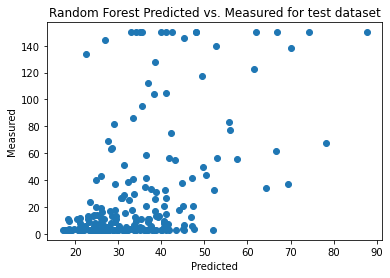

In [126]:
plt.scatter(predicted_test, measured_test)
plt.xlabel('Predicted')
plt.ylabel('Measured')
plt.title(r'Random Forest Predicted vs. Measured for test dataset')
plt.show()

In [128]:
metric1 = dc.metrics.Metric(dc.metrics.pearson_r2_score)
metric2 = dc.metrics.Metric(dc.metrics.r2_score)
print(best_rf.evaluate(train_dataset, [metric1, metric2], transformers=transformers))
print(best_rf.evaluate(valid_dataset, [metric1, metric2], transformers=transformers))
print(best_rf.evaluate(test_dataset, [metric1, metric2], transformers=transformers))

{'pearson_r2_score': 0.43625414120154066, 'r2_score': 0.30744344867380813}
{'pearson_r2_score': 0.20753657593138214, 'r2_score': 0.17608753457044157}
{'pearson_r2_score': 0.16843969235468484, 'r2_score': 0.1440241027758482}


In [ ]:
# #read data as pandas dataframes
# train_df = pd.read_hdf("../data/Microsomal_Clearance.train.scaffold.hdf")
# valid_df = pd.read_hdf("../data/Microsomal_Clearance.valid.scaffold.hdf")
# test_df = pd.read_hdf("../data/Microsomal_Clearance.test.scaffold.hdf")

#convert dataframes to csv
# infile_name = "train_scaffold.csv"
# train_df.to_csv(infile_name,index=False)

# infile_name = "valid_scaffold.csv"
# valid_df.to_csv(infile_name,index=False)

# infile_name = "test_scaffold.csv"
# test_df.to_csv(infile_name,index=False)